# Double Dueling Deep Q-Network (DQN) using PyTorch
Environment: LunarLander-v2

### Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


    

## Specify the Environment, and Explore the State and Action Spaces
* Let's begin with an initializing the environment


In [2]:
# Create an environment
env = gym.make('LunarLander-v2')
env.seed(0);
print('State space: ', env.observation_space)
print('State shape: ', env.observation_space.shape)

print('Action space: ', env.action_space)
print('Number of actions: ', env.action_space.n)


State space:  Box(8,)
State shape:  (8,)
Action space:  Discrete(4)
Number of actions:  4


### Implement Q-Network
Building the Network: Actor (policy) Model
input_size = state_size
output_size = action_size
using same seed
hidden_layers: fc1, fc2

<!-- Define Layer of model: [FC-RELU-FC-RELU-FC] -->



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        '''
        Builds a feedforward nework with two hidden layers
        Initialize parameters
        
        Params
        =========
        state_size (int): Dimension of each state (input_size)
        action_size (int): dimension of each action (output_size)
        seed (int): Random seed(using 0)
        fc1_units (int): Size of the first hidden layer
        fc2_units (int): Size of the second hidden layer
        '''
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Add the first laer, input to hidden layer
        self.fc1 = nn.Linear(state_size, fc1_units)
        # Add more hidden layer
        self.fc2 = nn.Linear(fc1_units, fc2_units)

        # State-value V
        self.V = nn.Linear(fc2_units, 1)
        
        # Advantage function A
        self.A = nn.Linear(fc2_units, action_size)
        
        
    def forward(self, state):
        """
        Forward pass through the network. Build a network that mps state -> action values.
        
        return Q function
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        V = self.V(x)
        A = self.A(x)
        
        return V + (A - A.mean(dim=1, keepdim=True))
    
    
# with out Dueling
# class QNetwork(nn.Module):
#     def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
#         '''
#         Builds a feedforward nework with two hidden layers
#         Initialize parameters
        
#         Params
#         =========
#         state_size (int): Dimension of each state (input_size)
#         action_size (int): dimension of each action (output_size)
#         seed (int): Random seed(using 0)
#         fc1_units (int): Size of the first hidden layer
#         fc2_units (int): Size of the second hidden layer
#         '''
#         super(QNetwork, self).__init__()
#         self.seed = torch.manual_seed(seed)
#         # Add the first laer, input to hidden layer
#         self.fc1 = nn.Linear(state_size, fc1_units)
#         # Add more hidden layer
#         self.fc2 = nn.Linear(fc1_units, fc2_units)
#         self.fc3 = nn.Linear(fc2_units, action_size)
        
#     def forward(self, state):
#         """
#         Forward pass through the network. Build a network that mps state -> action values.
#         """
#         x = F.relu(self.fc1(state))
#         x = F.relu(self.fc2(x))
#         return self.fc3(x)
        
        
        

# Experience Replay

### Set finite memory size N
Algorithm only stores the last N experience tuples in the replay memory, and sample uniformly at random from D when performing updates. The memory buffer does not differentiate imporant transitions and always overwrites with recent transitions owing to the finitre memory size N.

Uniform sampling gives equal importance to all transitions in the replay memory

We store each experienced tuple in the buffer as we are interacting with the environment and then sample a small bath of tuples from it in order to learn. Therefore, we are able to learn from individual tuples multiple times

Sequential order runs the risk of getting swayed by the effect of the correlations.

With experience replay, can sample from this buffer at random

Randomizing the samples breaks these correlations and therefore reduces the variance of the updates

In [4]:
import numpy as np
import random
from collections import namedtuple, deque

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        '''
        Only stroes the last N experience tuples in the replay memory

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        '''
        # Initialize replay memory
        self.acion_size = action_size
        self.memory = deque(maxlen=buffer_size) # set N memory size
        self.batch_size = batch_size
        # build named experience tuples
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        '''
        we store the agent's experiences at each time-step, e_t = (s_t,a_t,r_t,s_(t+1))
        '''
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        '''
        Samples uniformly at random from D(D_t = {e_1,...,e_t}) when  performing updates
        '''
        # D
        experiences = random.sample(self.memory, k=self.batch_size)
        #store in
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device) # gpu
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        # return D
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        '''
        Return the current size of internal memory
        '''
        return len(self.memory)
        
        
        

### Implement agent
* Agent(state_size=8, action_size=4, seed=0)

In [5]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

# hyperparameters
LR = 5e-4                # learning rate
BUFFER_SIZE = int(1e5)   # replay buffer size N
BATCH_SIZE = 64          # minibatch size
UPDATE_EVERY = 4         # how often to update the network
GAMMA = 0.99             # Discount factor
TAU = 1e-3               # for soft update of target parameters


# Setup Gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Build Agent(): Evaluate our agent on unmodified games (dqn agent)
class Agent():
    """
    
    """
    def __init__(self, state_size, action_size, seed): #8, 4, 0
        """
        Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state = 8
            action_size (int): dimension of each action = 4
            seed (int): random seed = 0
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network: Neural network function approx. with weights theta θ as a Q-Network.
        # A Q-Network can be trained by adjusting the parameters θ_i at iteration i to reduce the mse in the Bellman equation
        # The outputs correspond to the predicted Q-values of the individual action for input state
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device) # gpu
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        # specify optimizer(Adam)
        # optim.Adam(Qnet.parameters(), small learning rate)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR) ###
        
        # First, use a technique known as experience replay in which we stre the agent's experience at each time-step,
        # e_t= (s_t, a_t, r_t, s_(t_1)), in a data set D_t ={e_1,...,e_t},pooled over many episodes(where the end of an episode occurs when
        # a terminal state is reached) into a replay memory.
        #Initialize replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed) ###
        # Initialize time step (update every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        # save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps
        self.t_step =(self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # if enough samples are availabe in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE: ###
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA) ###
                
    def act(self, state, eps=0):
        '''
        Choose action A from state S using policy pi <- epsilon-Greedt(q^hat (S,A,w))
        Return actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection        
        '''
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        # It is off-policy: it learns about the greedy policy a = argmax Q(s,a';θ),
        # while following a behaviour distribution is often selected by an eps-greedy policy
        # that follows the greey policy with probability 1-eps and selects a random action
        # with probability eps.        
        # Epsilon-greedy action selection
        # 
        # with probability epsilon select a random action a_t
        # otherwise select a_t = argmax_a Q (phi(s_t),a; θ)
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma): #----only use the local and target Q-networks to compute the loss before taking a step towards minimizing the loss
        '''
        Update value parameters using given batch of experience tuples
        
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        
        '''
        states, actions, rewards, next_states, dones = experiences
        #####DQN
        ## Get max predicted Q values (for next states) from target model
        #Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        #
        ## Compute Q targets for current states
        #Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        #
        ## Get expected Q values from local model
        #Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ##### Double DQN
        self.qnetwork_local.eval()
        with torch.no_grad():
            # fetch max action arguemnt to pass
            Q_pred = self.qnetwork_local(next_states)
            max_actions = torch.argmax(Q_pred, dim=1).long().unsqueeze(1)
            # Q_targets over next statesfrom actions will be taken based on Q_pred's max_action
            Q_next = self.qnetwork_target(next_states)
        self.qnetwork_local.train()
        Q_targets = rewards + (gamma * Q_next.gather(1, max_actions) * (1.0 - dones))
        ## Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        
        ###############
        # apply loss fucntion
        # calculate the loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # zero the parameter (weight) gradients
        self.optimizer.zero_grad()
        
        # backward pass to calculate the parameter gradients
        loss.backward()
        
        # update the parameters
        self.optimizer.step()
        
        #################
        #Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) ###
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
        
        
        
        
        

# Watch an untrained agent

In [15]:
agent = Agent(state_size=8, action_size=4, seed=0)

agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
agent.qnetwork_target.load_state_dict(torch.load('checkpoint.pth'))

state = env.reset()

# Train the Agent with DQN
Train Deep Q-Learning with
* maximum number of training episodes: 2000
* maximum number of timesteps per episode: 1000
* starting value of epsilon for epsilon-greedy action selection: 1.0
* minimum value of epsilon: 0.01
* multiplacative factor (per episode for decreasing epsilon: 0.995

In [16]:
from collections import deque
import numpy as np
import torch

#double dueling dqn
def dqn(n_episodes = 2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Train the Agent with Deep Q-Learning
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    # Initialize collecting scores from each episode
    scores = []
    # Initialize collecting maxlen(100) scores
    scores_window = deque(maxlen=100)
    # initialize starting value of epsilon
    eps = eps_start
    
    # for each episode----------------
    for i_episode in range(1, n_episodes+1):
        # begin the episode
        state = env.reset()
        # initialize the sampled score(reward)
        score = 0
        
        # Set constrain maximum number of time step per episode
        for t in range(max_t):
            # agent select an action
            action = agent.act(state, eps)
            # agent performs the selected action
            next_state, reward, done, _ = env.step(action)
            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done)
            # update the sampled reward
            score += reward
            # update the state (s <- s') to next time step
            state = next_state
            if done:
                break
        #Save most recent score
        scores_window.append(score)
        #save most recent score
        scores.append(score)
        #Decrease epsilon
        eps = max(eps_end, eps_decay*eps)
        
        # monitor progress
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # get average reward from last 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\t Average Score:{:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=300.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100,
                                                                                         np.mean(scores_window)))
            # save model
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores
#double deuling dqn
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 1	 Average Score: -384.38
Episode 2	 Average Score: -331.23
Episode 3	 Average Score: -238.31
Episode 4	 Average Score: -237.00
Episode 5	 Average Score: -239.07
Episode 6	 Average Score: -214.21
Episode 7	 Average Score: -200.59
Episode 8	 Average Score: -176.54
Episode 9	 Average Score: -166.35
Episode 10	 Average Score: -155.12
Episode 11	 Average Score: -150.85
Episode 12	 Average Score: -141.18
Episode 13	 Average Score: -149.22
Episode 14	 Average Score: -151.48
Episode 15	 Average Score: -147.77
Episode 16	 Average Score: -141.44
Episode 17	 Average Score: -135.93
Episode 18	 Average Score: -139.23
Episode 19	 Average Score: -139.11
Episode 20	 Average Score: -137.97
Episode 21	 Average Score: -146.22
Episode 22	 Average Score: -146.80
Episode 23	 Average Score: -144.90
Episode 24	 Average Score: -142.67
Episode 25	 Average Score: -141.11
Episode 26	 Average Score: -142.86
Episode 27	 Average Score: -141.81
Episode 28	 Average Score: -140.06
Episode 29	 Average Score: -1

KeyboardInterrupt: 

AttributeError: 'function' object has no attribute 'display'

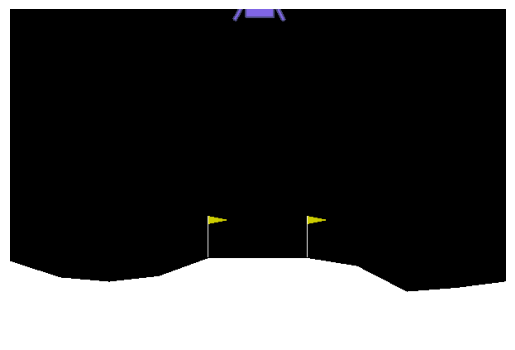

In [10]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(7):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(500):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()